https://medium.com/@jonathan_hui/rl-policy-gradients-explained-9b13b688b146
https://towardsdatascience.com/an-intuitive-explanation-of-policy-gradient-part-1-reinforce-aa4392cbfd3c

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym

In [2]:
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

In [3]:
SEED = 1234

train_env.seed(SEED);
test_env.seed(SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [5]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

policy = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [6]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [7]:
policy.apply(init_weights)

MLP(
  (fc_1): Linear(in_features=4, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [8]:
LEARNING_RATE = 0.01

policy_optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

In [9]:
def train(env, policy, optimizer, discount_factor):
    
    policy.train()
    
    log_prob_actions = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        action_pred = policy(state)
        
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)

        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, _ = env.step(action.item())

        log_prob_actions.append(log_prob_action)
        rewards.append(reward)

        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions)
        
    returns = calculate_returns(rewards, discount_factor)
        
    loss = update_policy(returns, log_prob_actions, optimizer)

    return loss, episode_reward

In [10]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
        
    return returns

In [11]:
def update_policy(returns, log_prob_actions, optimizer):
    
    returns = returns.detach()
    
    loss = - (returns * log_prob_actions).sum()
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    return loss.item()

In [12]:
def evaluate(env, policy):
    
    policy.eval()
    
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:
        
        state = torch.FloatTensor(state).unsqueeze(0)
        
        with torch.no_grad():
        
            action_pred = policy(state)
        
            action_prob = F.softmax(action_pred, dim = -1)
                            
        action = torch.argmax(action_prob, dim = -1)
            
        state, reward, done, _ = env.step(action.item())

        episode_reward += reward
        
    return episode_reward

In [13]:
MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10

episode_rewards = []

for episode in range(1, MAX_EPISODES+1):
    
    loss, episode_reward = train(train_env, policy, policy_optimizer, DISCOUNT_FACTOR)
    
    episode_reward = evaluate(test_env, policy)
    
    episode_rewards.append(episode_reward)
    
    mean_trial_rewards = np.mean(episode_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
    
        print(f'| Episode: {episode:3} | Mean Rewards: {mean_trial_rewards:5.1f} |')
    
    if mean_trial_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break

| Episode:  10 | Mean Rewards:   9.5 |
| Episode:  20 | Mean Rewards:  35.6 |
| Episode:  30 | Mean Rewards:  51.8 |
| Episode:  40 | Mean Rewards:  65.0 |
| Episode:  50 | Mean Rewards:  98.8 |
| Episode:  60 | Mean Rewards: 150.6 |
| Episode:  70 | Mean Rewards: 164.9 |
| Episode:  80 | Mean Rewards: 255.0 |
| Episode:  90 | Mean Rewards: 266.9 |
| Episode: 100 | Mean Rewards: 214.3 |
| Episode: 110 | Mean Rewards: 235.8 |
| Episode: 120 | Mean Rewards: 257.6 |
| Episode: 130 | Mean Rewards: 312.3 |
| Episode: 140 | Mean Rewards: 271.0 |
| Episode: 150 | Mean Rewards: 266.2 |
| Episode: 160 | Mean Rewards: 406.2 |
| Episode: 170 | Mean Rewards: 376.6 |
| Episode: 180 | Mean Rewards: 238.4 |
| Episode: 190 | Mean Rewards: 121.4 |
| Episode: 200 | Mean Rewards: 134.8 |
| Episode: 210 | Mean Rewards: 159.4 |
| Episode: 220 | Mean Rewards: 243.5 |
| Episode: 230 | Mean Rewards: 390.9 |
| Episode: 240 | Mean Rewards: 447.9 |
Reached reward threshold in 244 episodes


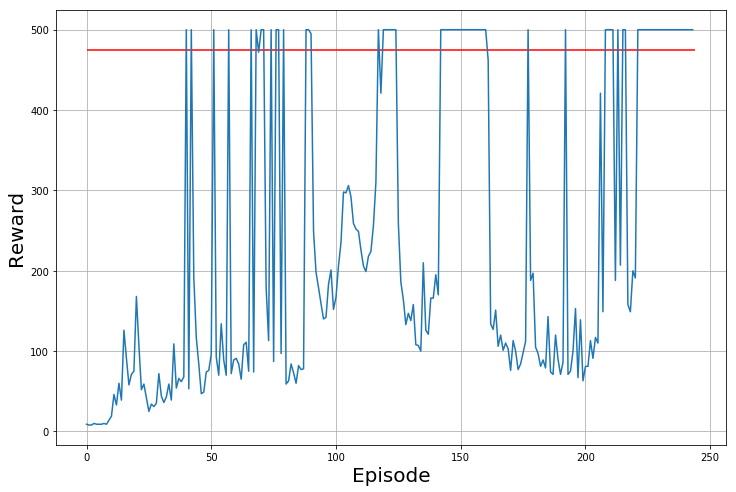

In [14]:
plt.figure(figsize=(12,8))
plt.plot(episode_rewards)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(episode_rewards), color='r')
plt.grid()